In [1]:
import pandas as pd
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
df = pd.read_csv(
    '/content/drive/MyDrive/emotion/tweet_emotions.csv',
    usecols=['content', 'sentiment'],
    dtype={'content': 'string', 'sentiment': 'category'}
)
df = df.rename(columns={'content': 'tweet', 'sentiment': 'label'})
labels = ['sadness', 'neutral', 'happiness', 'worry', 'love']
df = df.query('label in @labels')
df.label = df.label.cat.remove_unused_categories()
# Rename labels
df['label'] = df['label'].replace('sadness', 'negative')
df['label'] = df['label'].replace('worry', 'negative')
df['label'] = df['label'].replace('happiness', 'positive')
df['label'] = df['label'].replace('love', 'positive')
data = df.dropna().reset_index(drop=True)

In [4]:
data_pos = data.query('label == "positive"')[:300]
data_neu = data.query('label == "neutral"')[:300]
data_neg = data.query('label == "negative"')[:300]

data_final = pd.concat([data_pos, data_neu, data_neg])

<Axes: xlabel='label', ylabel='Count'>

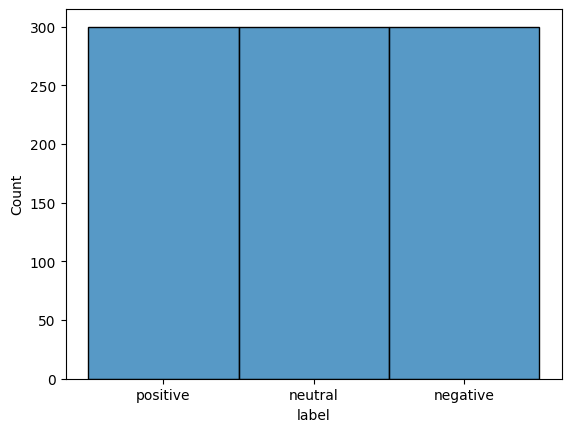

In [5]:
sns.histplot(data_final, x='label')

In [6]:
import keras
from transformers import pipeline

distilled_student_sentiment_classifier = pipeline(
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    tokenizer="lxyuan/distilbert-base-multilingual-cased-sentiments-student"
)

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [7]:
distilled_student_sentiment_classifier("I love this movie and i would watch it again and again!")

[{'label': 'positive', 'score': 0.9731044769287109}]

In [8]:
cardiffnlp_sentiment_classifier = pipeline(
    model='cardiffnlp/twitter-roberta-base-sentiment-latest',
    tokenizer='cardiffnlp/twitter-roberta-base-sentiment-latest'
)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [9]:
cardiffnlp_sentiment_classifier("I love this movie and i would watch it again and again!")

[{'label': 'positive', 'score': 0.9894440770149231}]

In [10]:
finiteautomata_sentiment_classifier = pipeline(
    model='finiteautomata/bertweet-base-sentiment-analysis',
    tokenizer='finiteautomata/bertweet-base-sentiment-analysis'
)

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


In [11]:
finiteautomata_sentiment_classifier("I love this movie and i would watch it again and again!")

[{'label': 'POS', 'score': 0.9923557043075562}]

In [12]:
import time

start_time = time.time()

i = 0

results = []

for index, row in data_final.iterrows():
    i += 1
    y_true = row["label"]
    X = row["tweet"]

    y_dict_1 = distilled_student_sentiment_classifier(X)[0]
    y_pred_1 = y_dict_1['label']
    y_pred_1_score = y_dict_1['score']

    y_dict_2 = cardiffnlp_sentiment_classifier(X)[0]
    y_pred_2 = y_dict_2['label']
    y_pred_2_score = y_dict_2['score']

    y_dict_3 = finiteautomata_sentiment_classifier(X)[0]
    y_pred_3 = y_dict_3['label']
    y_pred_3_score = y_dict_3['score']

    results.append([y_true, y_pred_1, y_pred_1_score, y_pred_2, y_pred_2_score, y_pred_3, y_pred_3_score])

    if i % 100 == 0:
        print(f'iteration {i}')
        print(f'{round(time.time() - start_time)} s')

    if i >= 1000:
        break

results_df = pd.DataFrame(results, columns=['y_true', 'y_1', 'y_1_score', 'y_2', 'y_2_score', 'y_3', 'y_3_score'])

iteration 100
40 s
iteration 200
73 s
iteration 300
107 s
iteration 400
137 s
iteration 500
166 s
iteration 600
195 s
iteration 700
229 s
iteration 800
260 s
iteration 900
290 s


In [13]:
results_df['y_3'] = results_df['y_3'].replace('NEG', 'negative')
results_df['y_3'] = results_df['y_3'].replace('NEU', 'neutral')
results_df['y_3'] = results_df['y_3'].replace('POS', 'positive')

0.4822222222222222


<Axes: xlabel='y_true', ylabel='Count'>

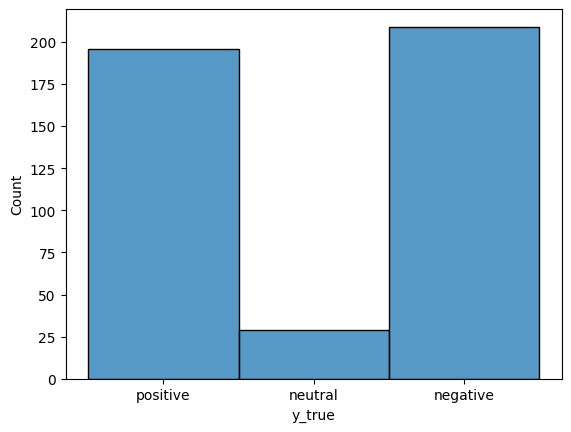

In [14]:
correct_1 = results_df.query('y_true == y_1')
print(len(correct_1)/len(results_df))
sns.histplot(correct_1, x='y_true')

0.6077777777777778


<Axes: xlabel='y_true', ylabel='Count'>

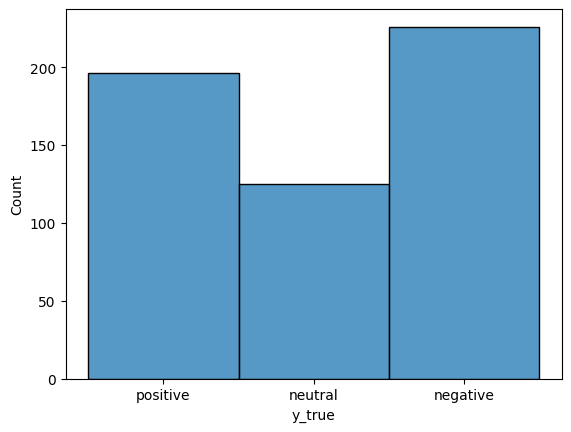

In [15]:
correct_2 = results_df.query('y_true == y_2')
print(len(correct_2)/len(results_df))
sns.histplot(correct_2, x='y_true')

0.6011111111111112


<Axes: xlabel='y_true', ylabel='Count'>

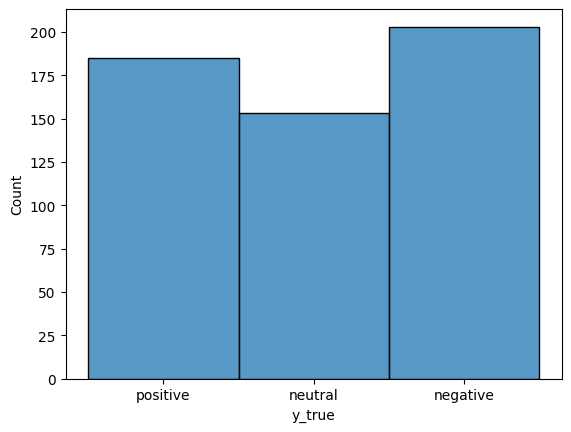

In [16]:
correct_3 = results_df.query('y_true == y_3')
print(len(correct_3)/len(results_df))
sns.histplot(correct_3, x='y_true')

In [17]:
correct = 0

for index, row in results_df.iterrows():
    y_true = row['y_true']

    #Voting Classifier Maximum voting
    y_preds = [row['y_1'], row['y_2'], row['y_3']]
    y_pred_vc = max(y_preds,key=y_preds.count)
    if y_pred_vc == y_true:
        correct += 1

print(correct/len(results_df))

0.59


In [18]:
correct = 0

for index, row in results_df.iterrows():
    y_true = row['y_true']

    #Voting Classifier Highest confidence voting
    y_preds = [row['y_1'], row['y_2'], row['y_3']]
    y_preds_scores = [row['y_1_score'], row['y_2_score'], row['y_3_score']]
    y_pred_vc = y_preds[y_preds_scores.index(max(y_preds_scores))]
    if y_pred_vc == y_true:
        correct += 1

print(correct/len(results_df))

0.6166666666666667
